# DS - Application Project <br>
# Developement of a Recommender System for Employee Skills - Rated Approach

## Preprocessing

Packages:

In [ ]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
# from sklearn.model_selection import train_test_split as scikit_train_test_split
from surprise import Reader, Dataset, accuracy
from surprise import KNNBasic, KNNWithMeans, SVD, CoClustering, SlopeOne, SVDpp, NMF, BaselineOnly
from surprise.model_selection import KFold, GridSearchCV
# from surprise.model_selection import train_test_split as surprise_train_test_split
import time

Data import:

In [ ]:
df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";")

Declare various aiding variables:

In [ ]:
PERSONS = df["person"].unique()
SKILLS = sorted(df["skill"].unique())
CATEGORIES = df["category"].unique()

In [ ]:
employee_dict = {}
for n in range(0,len(PERSONS)):
    employee_dict[n] = PERSONS[n]

In [ ]:
skills_to_category = pd.read_csv("data/mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

Since this notebook demonstrates the a recommender system which deals with rated skills and the underlying data does not offer ratings, this measure will be implemented in the following way: 
- For each skill, the frequency of the underlying category will be measured. The skills will be rated according to this frequency 
- For example: If an employee has most skills in the category "Programmiersprachen", these skills will receive the highest rating
- The ratings will be scaled to a range of 1 (being the lowest skill level) to 5 (being the highest skill level)

In [ ]:
def scaler_1_5(x:float,old_max:int,old_min:int):
    '''
    Function scaling a value x to a range of 1 (minimum) and 5 (maximum) with respective to the previous min and max values of the structure x is embedded in. 
    ----------
    Parameters: 
    x : float
    The data which is to be scaled
    old_min : int 
    Min value of the structure x is embedded in.
    old_max : int 
    Max value of the structure x is embedded in.
    ----------
    Returns: 
    Scaled x. 
    '''
    old_range = (old_max - old_min)  
    if (old_range == 0):
        return 1
    else:
        new_range = (5 - 1) 
        x_std = (x - old_min)/(old_max-old_min)
        return round(x_std * new_range + 1)

In [ ]:
category_per_employee = pd.DataFrame(index=df["category"].unique())
df_rated_2 = pd.DataFrame()
for p in df["person"].unique():
    p_skills = df[df["person"] == p]
    # # count categories for each employee
    category_count = p_skills["category"].value_counts()
    category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
    category_count
    skill_values = np.array([])
    # # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
    for cat in CATEGORIES:
        try:
            skill_values = np.append(skill_values,category_count[cat])
        except KeyError:
            skill_values = np.append(skill_values,0)
    # add employee data to dataframe
    p_skills_df = pd.DataFrame(index=CATEGORIES,columns=[p],data=skill_values)
    df_p_rated = pd.merge(df[df["person"] == p],p_skills_df,left_on="category",right_index=True).rename(columns={p:"rating"}).drop("category",axis=1)
    df_rated_2 = pd.concat([df_rated_2,df_p_rated],ignore_index=True)
df_rated_2

,person,skill,rating
0,12,Windows NT/2000/XP,4.0
1,12,MAC OS X,4.0
2,12,Windows 7,4.0
3,12,Windows 8,4.0
4,12,iOS,4.0
...,...,...,...
24581,1488,Promotion / Drools Engine,5.0
24582,1488,Hybris,5.0
24583,1488,Apache JMeter,1.0
24584,1488,Keycloak,1.0


In [ ]:
def get_rated_df(data):
    '''
    Function to add ratings to a skill dataset with underlying categories. 
    ----------
    Parameters: 
    data : pd.DataFrame
    The data with coulms: person, skill, category 
    ----------
    Returns: 
    Pandas DataFrame containing ratings for each skill according to underlying category frequency of skills. 
    '''
    category_per_employee = pd.DataFrame(index=df["category"].unique())
    df_rated = pd.DataFrame()
    for p in df["person"].unique():
        p_skills = df[df["person"] == p]
        # # count categories for each employee
        category_count = p_skills["category"].value_counts()
        category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
        category_count
        skill_values = np.array([])
        # # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
        for cat in CATEGORIES:
            try:
                skill_values = np.append(skill_values,category_count[cat])
            except KeyError:
                skill_values = np.append(skill_values,0)
        # add employee data to dataframe
        p_skills_df = pd.DataFrame(index=CATEGORIES,columns=[p],data=skill_values)
        df_p_rated = pd.merge(df[df["person"] == p],p_skills_df,left_on="category",right_index=True).rename(columns={p:"rating"}).drop("category",axis=1)
        df_rated = pd.concat([df_rated,df_p_rated],ignore_index=True)
    return df_rated

In [ ]:
# def get_rated_df(data):
#     '''
#     Function to add ratings to a skill dataset with underlying categories. 
#     ----------
#     Parameters: 
#     data : pd.DataFrame
#     The data with coulms: person, skill, category 
#     ----------
#     Returns: 
#     Pandas DataFrame containing ratings for each skill according to underlying category frequency of skills. 
#     '''
#     # create dataframe for each employee and their category count
#     category_per_employee = pd.DataFrame(index=data["category"].unique())
#     for p in data["person"].unique():
#         p_skills = data[data["person"] == p]
#         # count categories for each employee
#         category_count = p_skills["category"].value_counts()
#         category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
#         skill_values = np.array([])
#         # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
#         for cat in CATEGORIES:
#             try:
#                 skill_values = np.append(skill_values,category_count[cat])
#             except KeyError:
#                 skill_values = np.append(skill_values,0)
#         # add employee data to dataframe
#         p_skills_df = pd.DataFrame(index=CATEGORIES,columns=[p],data=skill_values)
#         category_per_employee = pd.concat([category_per_employee,p_skills_df],axis=1)

#     df_rated = pd.DataFrame()
#     for p in data["person"].unique():
#         # get employee
#         df_subset = data[data["person"] == p].copy()
#         # get skills of employee
#         p_skills = df_subset["skill"].to_numpy()
#         # initialize empty array for ratings
#         ratings = np.zeros(len(p_skills))
#         # fill array for each skill with respective category value 
#         for i in range(0,len(p_skills)): 
#             ratings[i] = category_per_employee.loc[category_dict[p_skills[i]]][p]
#         # append ratings to subset and drop category column
#         df_subset["rating"] = ratings
#         df_subset.drop("category",axis=1,inplace=True)
#         # append user to df
#         df_rated = pd.concat([df_rated,df_subset],ignore_index=True)

#     return df_rated

In [ ]:
df_rated = get_rated_df(df)

In [ ]:
df_rated

,person,skill,rating
0,12,Windows NT/2000/XP,4.0
1,12,MAC OS X,4.0
2,12,Windows 7,4.0
3,12,Windows 8,4.0
4,12,iOS,4.0
...,...,...,...
24581,1488,Promotion / Drools Engine,5.0
24582,1488,Hybris,5.0
24583,1488,Apache JMeter,1.0
24584,1488,Keycloak,1.0


Since this notebook is dealing with rated skills and the used models should deal with the true ratings of the skills, no further transformation, such as normalization of ratings, will be applied.

## Surpirse Library - Model Selection

In this chapter, different recommender systems, making use of collaborative filtering and matrix factorization will be compared regardings their performance on the data. Afterwards the best performing model will be used for further evaluation. 

Define holdout data: <br>
Since the recommendations of this approach should be comparable to the results of the binary approach, we need a uniform measure of comparison. One measure, which presents itself as suitable, is the precision of the recommendations. In other words, we want to measure in how far the recommender system will tend to recommend skill to our employee, which these employees would actually want to learn. To do so, 10% of high rated skills will be removed from the data prior to training the model and will be stored as holdout. During evaluation, the occurence of these exact skills among the recommendations will be measured. If the recommender system recommends skills to employee, which are in the holdout, meaning that the employee actually already knows this skill and also has a high rating asserted to it, we do have an objective measurement which validates the recommendations as meaningful. 

In [509]:
def get_rare_skills(data:pd.DataFrame,n:int):
    '''
    Function to determine all skills which occur less than n times in a given dataset.
    Dataset must be a pandas Dataframe with columns: person, skill.
    ----------
    Parameters: 
    data : pd.DataFrame
    The data in which rare skills are to be determined. 
    n : int 
    The threshold frequency.
    ----------
    Returns: 
    List of skills occuring less than n times in dataset.
    '''
    skill_frequency = {}
    for skill in data["skill"].unique():
        skill_frequency[skill] = data[data["skill"] == skill]["person"].nunique()

    return [s for s,f in skill_frequency.items() if f <= n]

In [ ]:
def get_holdout(data,size):
    # save original size of data for termination of while loop 
    size_data = len(data)
    holdout = pd.DataFrame()
    # get list which represents each employee with their number of entered skills in the data
    employee_occurence = data["person"].to_list()
    rare_skills = get_rare_skills(df_rated,1)
    # initialize random seed
    seed = 0 
    while len(holdout)/size_data < size:
        # randomly select employee (affected by how often they occur in the data)
        np.random.seed(seed)
        df_subset_emp = data[(data["person"] == np.random.choice(employee_occurence))]
        # prune rare skills from dataset so skills do not get randomly eliminated from training data
        df_subset_pruned = df_subset_emp[~df_subset_emp["skill"].isin(rare_skills)]
        # if condition causes that employee do not get completely deleted from dataset
        if len(df_subset_pruned) > 1:
            max_rating_emp = df_subset_pruned["rating"].max()
            holdout_emp = df_subset_pruned[df_subset_pruned["rating"] == max_rating_emp].sample(n=1,random_state=seed)
            data.drop(holdout_emp.index,inplace=True)
            holdout = pd.concat([holdout,holdout_emp],ignore_index=True)
        # change seed for next while iteration
        seed = seed + 1
    return holdout

In [ ]:
holdout = get_holdout(df_rated,0.1)

In [ ]:
holdout

,person,skill,rating
0,159,Magento,5.0
1,20,Swing,5.0
2,1411,DBase/Clipper,5.0
3,333,Windows 8,5.0
4,1038,SWT,5.0
...,...,...,...
2454,732,NHibernate,5.0
2455,315,JSP,5.0
2456,374,Google Web Toolkit,5.0
2457,1208,Confluence,3.0


Convert the Pandas DataFrame into a data structure suitable for the surprise library. 

***HIER EINMAL DIE DATEN MIT UND OHNE HOLDOUT EINLESEN UND DIE CV MIT ALLEN DATEN UND DAS MODELL DANN AUF DIE DATEN OHNE HOLDOUT FITTEN***

In [ ]:
reader = Reader(rating_scale=(1,5)) 
data = Dataset.load_from_df(df_rated,reader)

Define number of trials of the cross validation and splits of the data:

In [ ]:
NUM_TRIALS = 3
NUM_SPLITS = 5

Define cross validation procedure:

In [ ]:
def gridsearch_cv_surprise(algo_class,algo_name,param_grid,data,best_model_dict,best_params_dict):
    start = time.time()
    rmse = np.zeros(NUM_TRIALS)
    mse = np.zeros(NUM_TRIALS)
    mae = np.zeros(NUM_TRIALS)
    models = []
    params = []

    for seed in range(NUM_TRIALS):
        print("Running CV for model", algo_name ,"in Iteration:", seed ,"at", time.time()-start)
        cv = KFold(
                        n_splits=NUM_SPLITS,
                        random_state=seed
                    )
        gs = GridSearchCV(
                        algo_class,
                        param_grid, 
                        measures=["rmse","mse","mae"], 
                        cv=cv,refit="rmse"
                    )
        gs.fit(data)
        rmse[seed] = gs.best_score["rmse"]
        mse[seed] = gs.best_score["mse"]
        mae[seed] = gs.best_score["mae"]
        models.append(gs.best_estimator["rmse"])
        params.append(gs.best_params["rmse"])

    # hier noch erläutern, warum rmse als ausschlaggebene measure gewählt wird
    best_model_dict[algo_name] = models[np.argmin(rmse)]
    best_params_dict[algo_name] = params[np.argmin(rmse)]

    print("Total time: ", (time.time()-start), "sec.")
    return rmse, mse, mae 

In [ ]:
def add_result(results, name, rmse, mse, mae):
    '''
    Function adding the results returned by nested_cv to a dataframe. 
    Results will be aggregated for better comparison. 
    Parameters: 

    Output:
    results DataFrame containing an additional row
    '''
    row = pd.DataFrame({
        "name":name,
        "rmse_mean":rmse.mean(), 
        "rmse_std":rmse.std(), 
        "mse_mean":mse.mean(), 
        "mse_std":mse.std(), 
        "mae_mean":mae.mean(), 
        "mae_std":mae.std()
        },index=[0])
    return pd.concat([results,row],ignore_index=True)

In [477]:
results = pd.DataFrame()
best_model_dict = {}
best_params_dict = {}

Define algorithms to be compared as well as their individual parameter grid:

In [478]:
algo_list = [
                (BaselineOnly,"Baseline",{
                                                "verbose":[False]
                                    }),
                (KNNBasic,"k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (KNNWithMeans,"Centered k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (SVD,"SVD",{
                                                "n_factors": [1, 2, 5, 10, 20, 40],
                                                "n_epochs": [100, 200, 400, 800, 1000],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    }),
                (SVDpp,"SVD++",{
                                                "n_factors": [1, 2, 5, 10, 20, 40],
                                                "n_epochs": [100, 200, 500, 1000],
                                                "random_state":[1]
                                    }),
                (CoClustering,"CoClustering",{
                                                "n_cltr_u": [2, 3, 4],
                                                "n_cltr_i": [2, 3, 4],
                                                "n_epochs": [100, 200, 400, 800, 1000],
                                                "random_state":[1]
                                    }),
                (SlopeOne,"SlopeOne",{
                                    }),
                (NMF,"NMF",{
                                                "n_factors": [1, 2, 5, 10, 20, 40],
                                                "n_epochs": [20, 40, 80],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    })
            ]

In [479]:
for algo in algo_list:
    rmse, mse, mae = gridsearch_cv_surprise(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    results = add_result(results,algo[1],rmse, mse, mae)

Running CV for model Baseline in Iteration: 0 at 0.0
Running CV for model Baseline in Iteration: 1 at 0.23187589645385742
Running CV for model Baseline in Iteration: 2 at 0.4351170063018799
Total time:  0.6561093330383301 sec.
Running CV for model k-NN in Iteration: 0 at 0.0
Running CV for model k-NN in Iteration: 1 at 19.290062427520752
Running CV for model k-NN in Iteration: 2 at 38.34598922729492
Total time:  57.305530309677124 sec.
Running CV for model Centered k-NN in Iteration: 0 at 0.0
Running CV for model Centered k-NN in Iteration: 1 at 21.221959590911865
Running CV for model Centered k-NN in Iteration: 2 at 42.22833561897278
Total time:  63.44137907028198 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 240.3682029247284
Running CV for model SVD in Iteration: 2 at 474.42156171798706
Total time:  707.5092489719391 sec.
Running CV for model SVD++ in Iteration: 0 at 0.0
Running CV for model SVD++ in Iteration: 1 at 1947.88709402084

In [476]:
results

,name,rmse_mean,rmse_std,mse_mean,mse_std,mae_mean,mae_std
0,Baseline,0.922106,0.000432,0.850360,0.000784,0.724328,0.000154
1,k-NN,0.806148,0.000998,0.650042,0.001700,0.596807,0.000601
2,Centered k-NN,0.806420,0.001356,0.650554,0.002344,0.599105,0.000764
3,SVD,0.498386,0.002445,0.248490,0.002491,0.284842,0.000421
4,SVD++,0.502753,0.000288,0.252868,0.000301,0.293942,0.001391
5,CoClustering,0.868953,0.008069,0.755358,0.014058,0.656449,0.006212
6,SlopeOne,0.859582,0.000862,0.739040,0.001556,0.654939,0.000669
7,Baseline,0.922106,0.000432,0.850360,0.000784,0.724328,0.000154
8,k-NN,0.806148,0.000998,0.650042,0.001700,0.596807,0.000601
9,Centered k-NN,0.806420,0.001356,0.650554,0.002344,0.599105,0.000764


Both SVD and SVD++ show significantly smaller error values compared to the other models in the comparison

Select best performing model and fit it on full data:

In [480]:
#model = NMF(n_factors= 40, n_epochs = 120, biased = False, random_state= 1)
model = SVD(n_factors = 40, n_epochs = 1000, biased = False, random_state = 1)
# model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
trainset = data.build_full_trainset()
model.fit(trainset)

Predict ratings for all skills which the employees do not yet have (meaning which do not have an existing rating):

In [481]:
preds = model.test(trainset.build_anti_testset())

## Evaluation

In [482]:
def get_top_n(predictions, n):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = {}
    
    for uid, iid, true_r, est, _ in predictions:
        try:
                top_n[uid].append((iid, est))
        except KeyError:
                top_n[uid] = [(iid, est)]

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Get recommendations for all users:

In [483]:
def get_recommendations(preds,n):
    top_n = get_top_n(preds, n)
    recommendations = pd.DataFrame()

    for uid, user_ratings in top_n.items():
        recom = pd.DataFrame(index=[uid],data=[[iid for (iid, _) in user_ratings]])
        recommendations = pd.concat([recommendations,recom])

    return recommendations

In [484]:
get_recommendations(preds,5)

,0,1,2,3,4
12,pycharm,BizTalk,AIX,Eclipse,Java FX
13,NHibernate,Kendo UI,DevExpress,Microsoft Enterprise Library,BizTalk
15,Vue.js,SCSS,ITCSS,Cypress,jQuery
16,AngularJS,Magento,HTML5,Ajax,JSON
17,Redux,Browser Technologien,React,Windows Presentation Foundation (WPF),Java FX
...,...,...,...,...,...
1467,C/C++,Python,TypoScript,Ruby,VB/VBA
1474,Agile Methoden,jQuery,AngularJS,Yii,SCSS
1475,Windows Presentation Foundation (WPF),Entity Framework,LINQ,Vue.js,TopLink
1479,LINQ,DevExpress,ASP Generalist,Entity Framework,NHibernate


Get recommendations for one or many individual users:

In [485]:
def get_recommendations_for_employee(userids:list,n:int): 
    recommendation_df = pd.DataFrame()
    for user in userids: 
        recoms_for_user = pd.DataFrame(get_top_n(preds, n)[user],columns=["skill","rating"],index=[user for i in range(0,n)])
        recommendation_df = pd.concat([recommendation_df,recoms_for_user])
    recommendation_df["category"] = recommendation_df["skill"].apply(lambda x:category_dict[x])
    return recommendation_df

In [486]:
get_recommendations_for_employee([employee_dict[27]],10)

,skill,rating,category
84,Hybris,5.000000,SAP Commerce
84,Analytics,5.000000,Einsatzfelder / Erfahrungen / Schwerpunkte
84,Qualitätsmanagement,4.946138,Einsatzfelder / Erfahrungen / Schwerpunkte
84,Anforderungsanalyse,4.918970,Einsatzfelder / Erfahrungen / Schwerpunkte
84,Datahub Anbindung,4.857702,SAP Commerce
84,WCMS,4.825880,SAP Commerce
84,Markenstrategie,4.822918,Einsatzfelder / Erfahrungen / Schwerpunkte
84,Solr,4.815859,SAP Commerce
84,Softwareeinführung,4.798142,Einsatzfelder / Erfahrungen / Schwerpunkte
84,SAP ERP Anbindung,4.796958,SAP Commerce


#### Evaluation Using Precision Scores

Define precision measure: 

In [487]:
def precision_at_k(k,holdout,recommendations):
    precision = np.zeros(holdout["person"].nunique())
    
    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0

        for recom in recoms_emp:
            if recom in holdout_emp:
                score = score + 1

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [488]:
def weighted_precision_at_k(k,holdout,recommendations):
    precision = np.zeros(holdout["person"].nunique())

    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0
        num_hits = 0

        for j,recom in enumerate(recoms_emp):
            if recom in holdout_emp:
                num_hits = num_hits + 1
                score = score + (num_hits / (j+1))

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [493]:
precision_at_k(5,holdout,get_recommendations(preds,5))

0.2963228271251194

The above precision telss us that on average, around 4-5 recommendations of the top 10 recommencations fou a user are skills which are in the holdout, therefore skills the respective employee already knows. 

In [490]:
weighted_precision_at_k(10,holdout,get_recommendations(preds,10))

0.22613394070883153

The weighted precision at k takes the order in which the recommendations are given into account. 

#### Evaluation Using Top Skills and Skill Categories of Employees

In [491]:
def evaluate_employee_recoms(emp_id,n):
    fig, axes = plt.subplots(2,1,figsize=(10,8))
    # get categories of actual skills
    skill_catgegories = df[df["person"] == emp_id]["category"].value_counts()
    skill_catgegories.plot(ax=axes[0],
                            kind="barh",
                            #ylabel="Count",
                            title="Category Count of Actual Skills - Employee "+str(emp_id))
    top_n_skills = df_rated[df_rated["person"] == emp_id].sort_values(by="rating",ascending=False).head(n).reset_index()[["skill"]]
    # get categories of recommended skills
    recoms_for_emp = pd.DataFrame(get_recommendations(preds,n).loc[emp_id].T)
    recoms_catgories = recoms_for_emp.replace({emp_id:category_dict}).value_counts()
    indeces = []
    for index in recoms_for_emp.replace({emp_id:category_dict}).value_counts().index:
        indeces.append(index[0])
    recoms_catgories.index = indeces
    recoms_catgories.plot(ax = axes[1],
                            kind = "barh",
                            xticks = np.arange(0,recoms_catgories.max()+1,1),
                            #ylabel="Count",
                            title = "Category Count of Recommended Skills - Employee "+str(emp_id))
    # create of top skills and recommendation for better comparison
    return_table = pd.concat([top_n_skills,recoms_for_emp],axis=1,ignore_index=True)
    return_table.columns = ["Top " + str(n) + " Actual Skills","Recommendations"]
    return return_table

,Top 10 Actual Skills,Recommendations
0,SCSS,Vue.js
1,Yii,xHTML
2,JSON,HTML5
3,iOS,Angular (2 und höher)
4,SUSE Linux,HTML
5,Windows 10,jQuery
6,Windows NT/2000/XP,PHP
7,Windows 7,Jest
8,Windows Vista,CSS
9,MAC OS X,Ajax


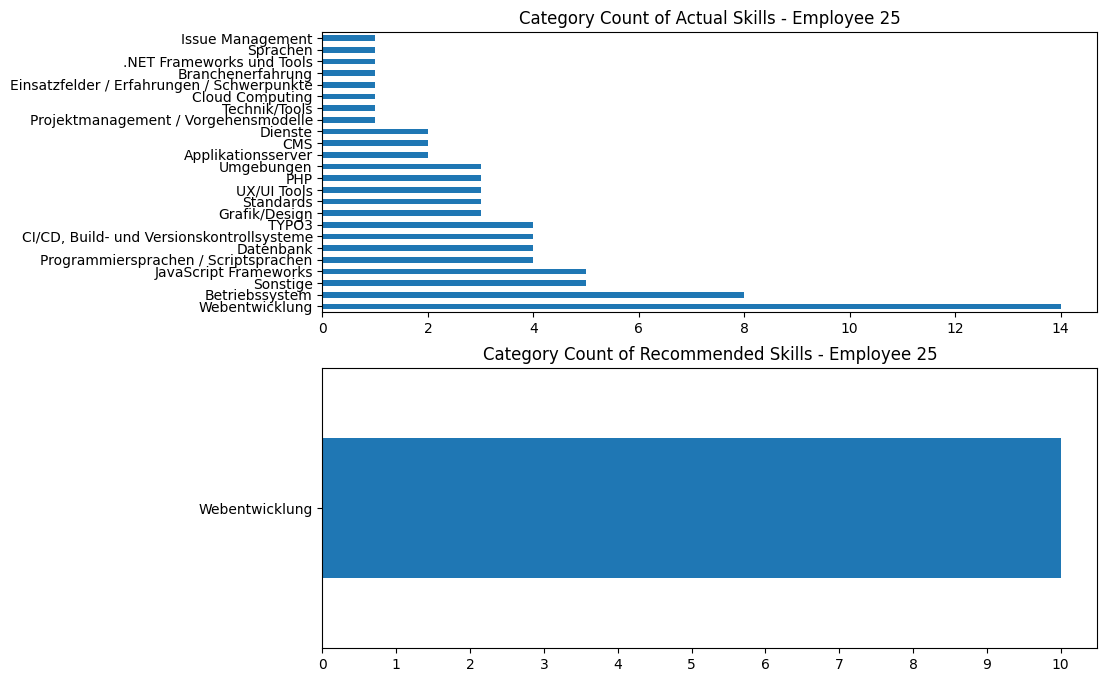

In [ ]:
evaluate_employee_recoms(employee_dict[8],10)

#### Evaluation Using Commonly Used Baselines

##### Surprise's Baseline

In [ ]:
baseline = BaselineOnly(verbose=False)
baseline.fit(trainset)
baseline_preds = baseline.test(trainset.build_anti_testset())

In [ ]:
baseline_recommendations = get_recommendations(baseline_preds,5)
baseline_recommendations

,0,1,2,3,4
12,TestNG,Jakarta Commons,EJB 3,Struts 2,Angular (2 und höher)
13,TestNG,Jakarta Commons,EJB 3,JDBC,Spring
15,TestNG,Jakarta Commons,EJB 3,JDBC,Spring
16,TestNG,Jakarta Commons,EJB 3,JDBC,Spring
17,TestNG,Jakarta Commons,EJB 3,JDBC,Spring
...,...,...,...,...,...
1467,TestNG,Jakarta Commons,EJB 3,JDBC,Spring
1474,TestNG,Jakarta Commons,EJB 3,JDBC,Spring
1475,TestNG,Jakarta Commons,EJB 3,JDBC,Spring
1479,TestNG,Jakarta Commons,EJB 3,JDBC,Spring


In [494]:
precision_at_k(5,holdout,baseline_recommendations) 

0.0683381088825215

In [495]:
weighted_precision_at_k(5,holdout,baseline_recommendations) 

0.04348376313276027

##### Most Often Occurring Skills

In [496]:
most_common_skills = list(df["skill"].value_counts().nlargest(5).index)

recom_list = []
for person in range(0,len(PERSONS)):
    recom_list.append(most_common_skills)

baseline_2_recoms = pd.DataFrame(index=PERSONS,columns=np.arange(0,5),data=recom_list)
baseline_2_recoms

,0,1,2,3,4
12,Englisch,MySQL,SCRUM,GIT,HTML
13,Englisch,MySQL,SCRUM,GIT,HTML
15,Englisch,MySQL,SCRUM,GIT,HTML
16,Englisch,MySQL,SCRUM,GIT,HTML
17,Englisch,MySQL,SCRUM,GIT,HTML
...,...,...,...,...,...
1467,Englisch,MySQL,SCRUM,GIT,HTML
1474,Englisch,MySQL,SCRUM,GIT,HTML
1475,Englisch,MySQL,SCRUM,GIT,HTML
1479,Englisch,MySQL,SCRUM,GIT,HTML


In [497]:
precision_at_k(5,holdout,baseline_2_recoms)

0.03595988538681948

In [498]:
weighted_precision_at_k(5,holdout,baseline_2_recoms)

0.008994746895893028

## Recommendations

### Recommendations for New Employees

In [499]:
# def get_recoms_for_new_employee(new_id,skilldict,model):

#     all_ids = df_rated["person"].unique()
#     all_skills = df_rated["skill"].unique()

#     if new_id in all_ids:
#         return "Error: ID already taken. Please choose a different ID an try again."
#     for skill in skilldict.keys():
#         if skill not in all_skills:
#             return "Skill " + skill + " not in database."
#             # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

#     new_test = []
#     for skill in all_skills:
#         try:
#             skill_rating = skilldict[skill]
#             new_test.append((new_id,skill,skill_rating))
#         except KeyError:
#             new_test.append((new_id,skill,np.nan))
    
#     predictions = model.test(new_test)

#     return get_top_n(predictions, n=10)[new_id]

In [500]:
new_id = 8774
new_skills = {
                # "Windows 11":4,
                "Englisch":4,
                # "Chinesisch (Mandarin)":2,
                "Python":4,
                # "MATLAB":2,
                "Java":2,
                "MySQL":3,
                "SQLBase":3,
                "Microsoft SQL Server":3,
                # "Google Cloud Platform":2,
                "MongoDB":1,
                "JSON":1,
                "Docker":2,
                # "Power BI":3,
                # "Postman":2,
                "PowerShell":2,
                # "Github actions":2
            }

In [501]:
def get_recoms_for_new_employee(new_id,new_skills,n):
    if new_id in PERSONS:
        return "Error: ID already taken. Please choose a different ID an try again."
    for skill in new_skills.keys():
        if skill not in SKILLS:
            return "Skill " + skill + " not in database."
            # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

    new_employee_df = pd.DataFrame()
    new_employee_df["skill"] = new_skills.keys()
    new_employee_df["rating"] = new_skills.values()
    new_employee_df["person"] = new_id
    new_employee_df = new_employee_df[["person","skill","rating"]]

    df_rated_new = pd.concat([df_rated,new_employee_df],ignore_index=True)
    # COMMENT: right now this function creates a new rated df. In order for this to retain newly added employees, it needs to overwrite the old df with the new data. 
    # this had to be implemented later on

    new_data = Dataset.load_from_df(df_rated_new,reader)

    model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
    #  COMMENT: right now the best model from the initial gridearch is taken. if the model is indeed to be retrained, it should be executing a new gridsearch and take the best estimator from this one
    trainset = new_data.build_full_trainset()
    model.fit(trainset)

    testset = trainset.build_anti_testset()
    predictions = model.test(testset)

    return get_top_n(predictions, n)[new_id]

In [502]:
get_recoms_for_new_employee(new_id,new_skills,5)

[('pycharm', 5),
 ('Dart', 4.819606480353084),
 ('Produktkonfigurator', 4.710931072844646),
 ('Flutter', 4.4385336261879695),
 ('Deutsch', 4.357598644374464)]

## Conclusion

## Appendix I - Effect of Dropping Rare Skills on Recommender Precision


In [504]:
min_absolute_support = [0, 1, 2, 5, 10, 20]

In [505]:
def measure_performance_for_n(n):
    df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";")
    # trim dataset according to min absolute support of skills and insert ratings afterwards
    rare_skills = get_rare_skills(df,n)
    df_rated = get_rated_df(df[~df["skill"].isin(rare_skills)])
    # get holdout for later precision measurement 
    holdout = get_holdout(df_rated,0.1)
    # transform data to surprise dataset
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df_rated,reader)
    # measure sparsity (ratio between non-zero and zero value entries)
    sparsity = len(df_rated)/(df_rated["person"].nunique()*df_rated["skill"].nunique())
    algo = (SVD,"SVD",{
                        #"n_factors": [1, 2, 5, 10, 20, 40],
                        "n_factors": [20],
                        "n_epochs": [500],
                        #"n_epochs": [100, 200, 400, 800, 1000],
                        "biased":[False],
                        #"biased":[True,False],
                        "random_state":[1]
                                        })
    best_model_dict = {}
    best_params_dict = {}
    rmse, mse, mae = gridsearch_cv_surprise(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    # define model, fit and test it on the data
    model = best_model_dict["SVD"]
    trainset = data.build_full_trainset()
    model.fit(trainset)
    preds = model.test(trainset.build_anti_testset())
    # save performance measures in df
    return pd.DataFrame({
                "n":n,
                "unique_skills":df_rated["skill"].nunique(),
                "sparsity":sparsity,
                "precision_at_k":precision_at_k(5,holdout,get_recommendations(preds,5)),
                "weighted_precision_at_k":weighted_precision_at_k(5,holdout,get_recommendations(preds,5)),
                "SVD - n_factors":best_params_dict["SVD"]["n_factors"],
                "SVD - mean rmse": np.mean(rmse),
                "SVD - mean mse": np.mean(mse),
                "SVD - mean mae": np.mean(mae)
                },index=[0])

In [507]:
measure_performance_for_n(5)

Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.01323676109314
Running CV for model SVD in Iteration: 2 at 10.056267499923706
Total time:  15.243481159210205 sec.


,n,unique_skills,sparsity,precision_at_k,weighted_precision_at_k,SVD - n_factors,SVD - mean rmse,SVD - mean mse,SVD - mean mae
0,5,723,0.075754,0.260984,0.167317,20,0.519268,0.269735,0.302947


In [508]:
result_df = pd.DataFrame()#columns = ["n","sparsity","precision_at_k","weighted_precision_at_k","SVD - n_factors"])
for n in min_absolute_support:
    print(n)
    result_df = pd.concat([result_df,measure_performance_for_n(n)],ignore_index=True)
result_df

0
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.048776865005493
Running CV for model SVD in Iteration: 2 at 15.838393449783325
Total time:  27.907456159591675 sec.
1
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.262986898422241
Running CV for model SVD in Iteration: 2 at 10.423205375671387
Total time:  15.58574366569519 sec.
2
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.170526027679443
Running CV for model SVD in Iteration: 2 at 10.371156454086304
Total time:  15.781741857528687 sec.
5
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.24550461769104
Running CV for model SVD in Iteration: 2 at 10.576677083969116
Total time:  15.756990194320679 sec.
10
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.282346963882446
Running CV for model SVD in Iteration: 2 

,n,unique_skills,sparsity,precision_at_k,weighted_precision_at_k,SVD - n_factors,SVD - mean rmse,SVD - mean mse,SVD - mean mae
0,0,723,0.075754,0.260984,0.167317,20,0.519268,0.269735,0.302947
1,1,723,0.075754,0.260984,0.167317,20,0.519268,0.269735,0.302947
2,2,723,0.075754,0.260984,0.167317,20,0.519268,0.269735,0.302947
3,5,723,0.075754,0.260984,0.167317,20,0.519268,0.269735,0.302947
4,10,723,0.075754,0.260984,0.167317,20,0.519268,0.269735,0.302947
5,20,723,0.075754,0.260984,0.167317,20,0.519268,0.269735,0.302947


In [ ]:
result_df = pd.DataFrame()#columns = ["n","sparsity","precision_at_k","weighted_precision_at_k","SVD - n_factors"])
for n in min_absolute_support:
    # get data 
    df = pd.read_csv("person-skills_2022-06-27.csv",sep=";")
    # trim dataset according to min absolute support of skills and insert ratings afterwards
    rare_skills = get_rare_skills(df,n)
    df_rated = get_rated_df(df[~df["skill"].isin(rare_skills)])
    # get holdout for later precision measurement 
    holdout = get_holdout(df_rated,0.1)
    # transform data to surprise dataset
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df_rated,reader)
    # measure sparsity (ratio between non-zero and zero value entries)
    sparsity = len(df_rated)/(df_rated["person"].nunique()*df_rated["skill"].nunique())
    algo = (SVD,"SVD",{
                        #"n_factors": [1, 2, 5, 10, 20, 40],
                        "n_factors": [20],
                        "n_epochs": [500],
                        #"n_epochs": [100, 200, 400, 800, 1000],
                        "biased":[False],
                        #"biased":[True,False],
                        "random_state":[1]
                                        })
    best_model_dict = {}
    best_params_dict = {}
    rmse, mse, mae = gridsearch_cv_surprise(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    # define model, fit and test it on the data
    model = best_model_dict["SVD"]
    trainset = data.build_full_trainset()
    model.fit(trainset)
    preds = model.test(trainset.build_anti_testset())
    # save performance measures in df
    new_entry = pd.DataFrame({
                "n":n,
                "unique_skills":df_rated["skill"].nunique(),
                "sparsity":sparsity,
                "precision_at_k":precision_at_k(5,holdout,get_recommendations(preds,5)),
                "weighted_precision_at_k":weighted_precision_at_k(5,holdout,get_recommendations(preds,5)),
                "SVD - n_factors":best_params_dict["SVD"]["n_factors"],
                "SVD - mean rmse": np.mean(rmse),
                "SVD - mean mse": np.mean(mse),
                "SVD - mean mae": np.mean(mae)
                },index=[0])
    result_df = pd.concat([result_df,new_entry],ignore_index=True)
result_df

Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.581098318099976
Running CV for model SVD in Iteration: 2 at 11.127289056777954
Total time:  16.72625422477722 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.683366775512695
Running CV for model SVD in Iteration: 2 at 11.543635129928589
Total time:  17.168832302093506 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.551813840866089
Running CV for model SVD in Iteration: 2 at 10.897157669067383
Total time:  16.353073835372925 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.507261037826538
Running CV for model SVD in Iteration: 2 at 10.940456628799438
Total time:  16.32264256477356 sec.
Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 5.0779337882995605
Running CV for model SVD in Iteration: 2 at 10.0194

,n,unique_skills,sparsity,precision_at_k,weighted_precision_at_k,SVD - n_factors,SVD - mean rmse,SVD - mean mse,SVD - mean mae
0,0,735,0.074517,0.099470,0.051755,20,NaN,NaN,NaN
1,1,666,0.082206,0.104789,0.053932,20,NaN,NaN,NaN
2,2,615,0.088861,0.112419,0.056886,20,NaN,NaN,NaN
3,5,511,0.105193,0.433606,0.210799,20,0.468040,0.219265,0.276086
4,10,393,0.131713,0.447496,0.226797,20,0.459824,0.211563,0.265496
5,20,270,0.178086,0.614572,0.342417,20,0.430344,0.185446,0.243818


Observations: <br>

## Appendix II - Reverse Problem for User Recommendations on Items

In [ ]:
df_items = df_rated[["skill","person","rating"]].sort_values(by="skill")
reader = Reader(rating_scale=(1,5)) 
data_items = Dataset.load_from_df(df_items,reader)
model = SVD(n_factors = 40, n_epochs = 1000, biased = False, random_state = 1)
trainset = data_items.build_full_trainset()
model.fit(trainset)

In [ ]:
preds = model.test(trainset.build_anti_testset())

In [ ]:
get_top_n(preds,10)["Python"]

[(1467, 4.864081714550778),
 (557, 4.8376254268004555),
 (1176, 4.826055747576279),
 (319, 4.819753842651815),
 (172, 4.773519718893669),
 (942, 4.747092928465232),
 (1290, 4.715950846172606),
 (147, 4.694484041464714),
 (855, 4.671964733867797),
 (464, 4.663455855885267)]

In [ ]:
df[df["person"] == 1467]["category"].value_counts()

Programmiersprachen / Scriptsprachen    3
Betriebssystem                          2
Datenbank                               1
Java Frameworks                         1
Webentwicklung                          1
Name: category, dtype: int64